In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras as keras
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
overviewData = pd.read_csv("NN_Project_2.csv", index_col = 0, header=0)


In [3]:
overviewData.head()

,PAYMENT_AMOUNT,NUMBER_OF_PAYMENTS,LETTERS_COUNT
MONTH_YEAR,,,
1990,20.00,1,1
1992,10.00,1,1
1993,440.47,18,47
1994,18028.23,39,85
1995,6171.59,71,155


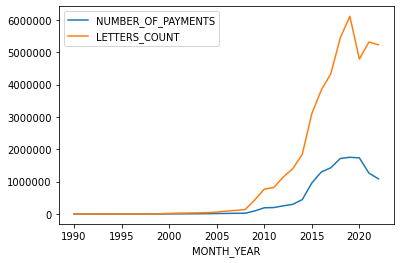

In [4]:
overviewData.plot(y=["NUMBER_OF_PAYMENTS", "LETTERS_COUNT"])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.ticklabel_format(style='plain')
plt.draw()

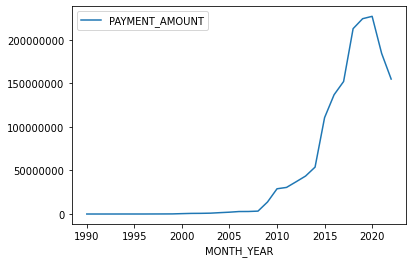

In [5]:
overviewData.plot(y=["PAYMENT_AMOUNT"])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.ticklabel_format(style='plain')
plt.draw()

In [6]:
train = pd.read_csv("NN_Project.csv",index_col=0,  header=0)

In [7]:
train.head()

,NUMBER_OF_ACCOUNTS,PLACEMENT_AMOUNT,PAYMENT_AMOUNT,REV,LETTERS_COUNT
MONTH_YEAR,,,,,
1990-06,1,275.63,20.0,255.63,1
1992-11,2,3203.20,10.0,3193.20,1
1993-02,1,613.28,70.0,543.28,3
1993-03,2,14850.00,10.0,14840.00,4
1993-04,1,2120.00,40.0,2080.00,2


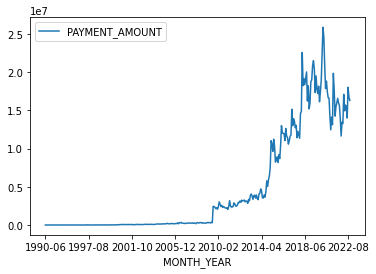

In [8]:
train.plot(y=["PAYMENT_AMOUNT"])
plt.draw()

In [9]:
def get_sub_dataset(data,year):
    dfb = data.index.values
    listTMP = []
    for i,x in enumerate(dfb):
        if str(year) in x:
            listTMP.append(i)
    return listTMP[0],listTMP[-1]+1

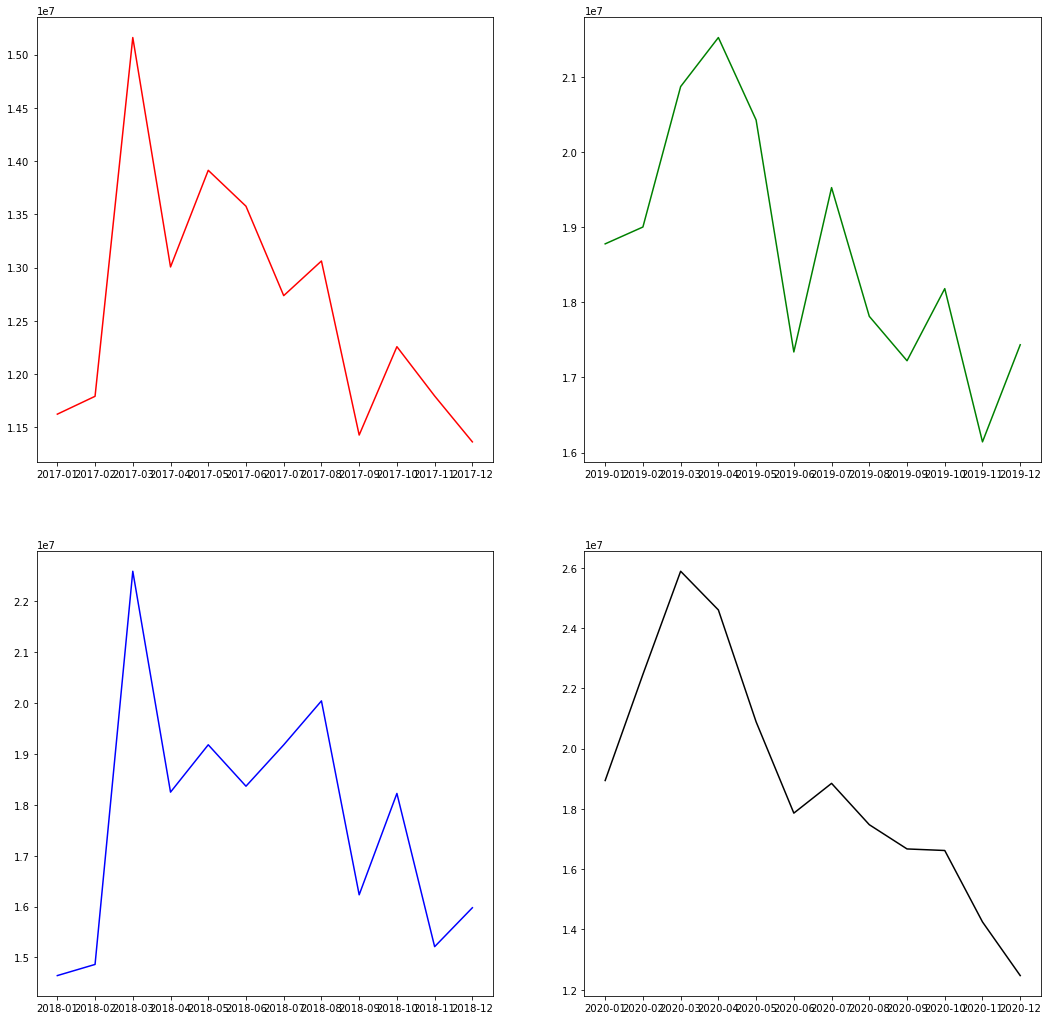

In [10]:
plt.rcParams["figure.figsize"] = (18,18)

fig, ax = plt.subplots(2, 2)
start,end = get_sub_dataset(train,2017)
subTrain = train[start:end]
ax[0, 0].plot(subTrain["PAYMENT_AMOUNT"], 'r') #row=0, col=0

start,end = get_sub_dataset(train,2018)
subTrain = train[start:end]
ax[1, 0].plot(subTrain["PAYMENT_AMOUNT"], 'b') #row=1, col=0

start,end = get_sub_dataset(train,2019)
subTrain = train[start:end]
ax[0, 1].plot(subTrain["PAYMENT_AMOUNT"], 'g') #row=0, col=1

start,end = get_sub_dataset(train,2020)
subTrain = train[start:end]
ax[1, 1].plot(subTrain["PAYMENT_AMOUNT"], 'k') #row=1, col=1

plt.show()

In [11]:
#remove bad data
train = train[11:]

In [12]:
#normalized_df=(train-train.min())/(train.max()-train.min())
normalized_df=train

In [13]:
normalized_df.head(10)

,NUMBER_OF_ACCOUNTS,PLACEMENT_AMOUNT,PAYMENT_AMOUNT,REV,LETTERS_COUNT
MONTH_YEAR,,,,,
1994-01,3,1555.08,25.00,1530.08,10
1994-02,1,231.27,40.00,191.27,6
1994-03,1,430.00,993.75,-563.75,9
1994-04,4,5802.98,142.00,5660.98,9
1994-05,2,542.18,12747.37,-12205.19,7
1994-06,4,4549.31,806.75,3742.56,5
1994-08,5,5264.79,973.36,4291.43,9
1994-09,1,1903.79,2225.00,-321.21,21
1994-12,1,4207.38,75.00,4132.38,9


In [14]:
month = []
for yearMonth in train.index.values:
    month.append(int(yearMonth.split("-")[1]))
normalized_df["MONTH"] = month

/tmp/ipykernel_295/2351384591.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df["MONTH"] = month


In [15]:
def df_to_X_y(df, window_size = 6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [np.array(a) for a in df_as_np[i:i+window_size,2]]
        X.append(row)
        label = df_as_np[i+5][2]
        y.append(label)
    return np.array(X),np.array(y)

def load_data(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

# Full dataset

In [16]:
normalized_df.head(10)

,NUMBER_OF_ACCOUNTS,PLACEMENT_AMOUNT,PAYMENT_AMOUNT,REV,LETTERS_COUNT,MONTH
MONTH_YEAR,,,,,,
1994-01,3,1555.08,25.00,1530.08,10,1
1994-02,1,231.27,40.00,191.27,6,2
1994-03,1,430.00,993.75,-563.75,9,3
1994-04,4,5802.98,142.00,5660.98,9,4
1994-05,2,542.18,12747.37,-12205.19,7,5
1994-06,4,4549.31,806.75,3742.56,5,6
1994-08,5,5264.79,973.36,4291.43,9,8
1994-09,1,1903.79,2225.00,-321.21,21,9
1994-12,1,4207.38,75.00,4132.38,9,12


In [17]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(normalized_df)

In [18]:
features = data_scaled
target = data_scaled[:,2]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=.15,random_state=12,shuffle= False)

In [20]:
window_length = 6
num_features = 6
train_generator = keras.preprocessing.sequence.TimeseriesGenerator(X_train,y_train,length=window_length,sampling_rate=1,batch_size=1)
test_generator = keras.preprocessing.sequence.TimeseriesGenerator(X_test,y_test,length=window_length,sampling_rate=1,batch_size=1)

In [21]:
data_train = []
data_test = []

for x in train_generator:
    data_train.append(x[1])
for x in test_generator:
    data_test.append(x[1])
data_train = np.array(data_train)
data_test = np.array(data_test)
data_train.shape,data_test.shape

((284, 1), (46, 1))

In [22]:
data_train = pd.DataFrame(data_train)
data_test = pd.DataFrame(data_test)
index = []
for i in range(len(data_train),len(data_train)+len(data_test)):
    index.append(i)
data_test.index = index


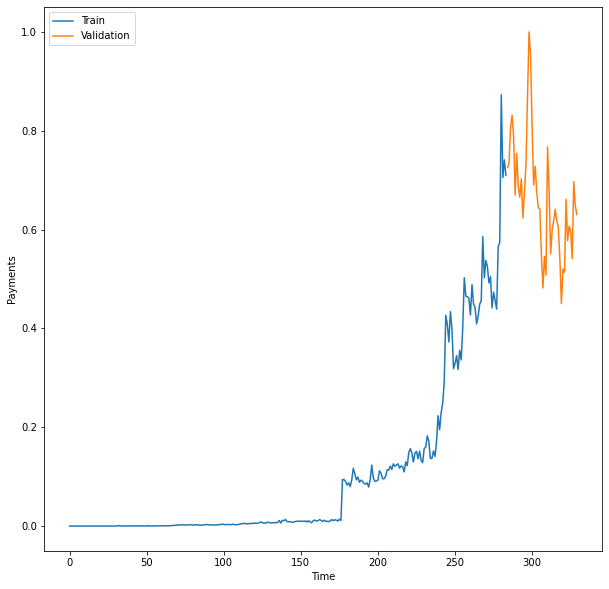

In [23]:

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(data_train)

plt.plot(data_test)
plt.xlabel("Time")
plt.ylabel("Payments")
plt.legend(['Train', 'Validation'])



2022-12-07 17:53:08.502870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-07 17:53:08.502901: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-07 17:53:08.502927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-rbm3d): /proc/driver/nvidia/version does not exist
2022-12-07 17:53:08.503234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 6, 128)            69120     
                                                                 
 normalization (Normalizatio  (None, 6, 128)           257       
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 6, 128)            0         
                                                              

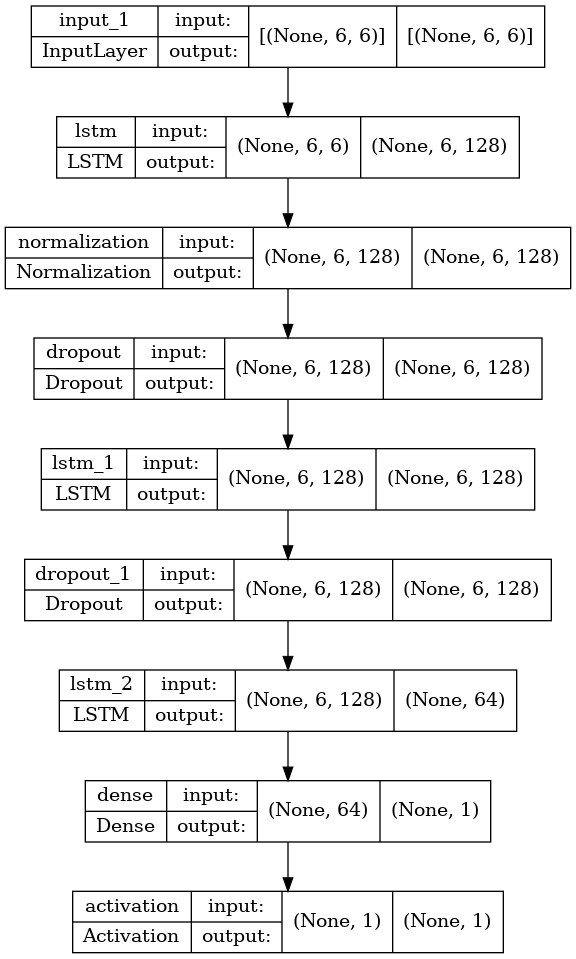

In [24]:
x = keras.layers.Input(shape=(window_length,num_features))
i = x

i = keras.layers.LSTM(
                input_shape=(window_length,num_features),
                units =128,
                return_sequences=True)(i)
i = keras.layers.Normalization()(i)
i = keras.layers.Dropout(.1)(i)
i =keras.layers.LSTM(
                units = 128,
                return_sequences=True)(i)
i = keras.layers.Dropout(.2)(i)
i =keras.layers.LSTM(
                units = 64,
                return_sequences=False)(i)
i = keras.layers.Dense(1)(i)
i = Activation('linear')(i)


model = keras.Model(x,i,name='LSTM')
model.compile(loss='mse', optimizer=keras.optimizers.RMSprop(),metrics=[tf.metrics.MeanAbsoluteError()])
model.summary()
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)

In [25]:
history = model.fit(train_generator,
    validation_data = test_generator,
    epochs=50)

Epoch 1/50
284/284 [==============================] - 8s 14ms/step - loss: 0.0059 - mean_absolute_error: 0.0437 - val_loss: 0.0101 - val_mean_absolute_error: 0.0712
Epoch 2/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0034 - mean_absolute_error: 0.0331 - val_loss: 0.1896 - val_mean_absolute_error: 0.4240
Epoch 3/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0292 - val_loss: 0.0122 - val_mean_absolute_error: 0.0896
Epoch 4/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0030 - mean_absolute_error: 0.0284 - val_loss: 0.0132 - val_mean_absolute_error: 0.0830
Epoch 5/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0027 - mean_absolute_error: 0.0279 - val_loss: 0.0124 - val_mean_absolute_error: 0.0828
Epoch 6/50
284/284 [==============================] - 3s 10ms/step - loss: 0.0021 - mean_absolute_error: 0.0261 - val_loss: 0.0188 - val_mean_absolute_error: 0.1052
Epoch 7/50

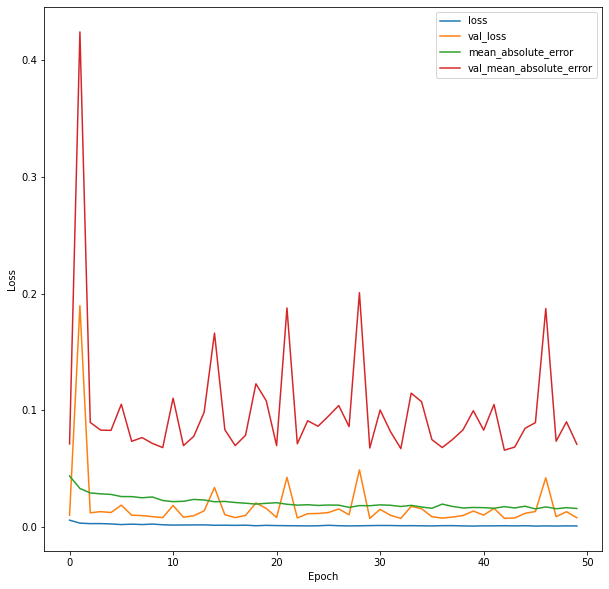

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['loss','val_loss','mean_absolute_error','val_mean_absolute_error'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [27]:
predic_generator = keras.preprocessing.sequence.TimeseriesGenerator(features,target,length=window_length,sampling_rate=1,batch_size=1)

In [28]:
train_predictions = model.predict(predic_generator)

In [29]:
real_results = []
for x in predic_generator:
    real_results.append(x[-1])
real_results = np.array(real_results)
real_results = real_results.reshape(len(real_results),1)
train_predictions = train_predictions.reshape(len(train_predictions),)

real_results.shape,train_predictions.shape,len(normalized_df.index)


((336, 1), (336,), 342)

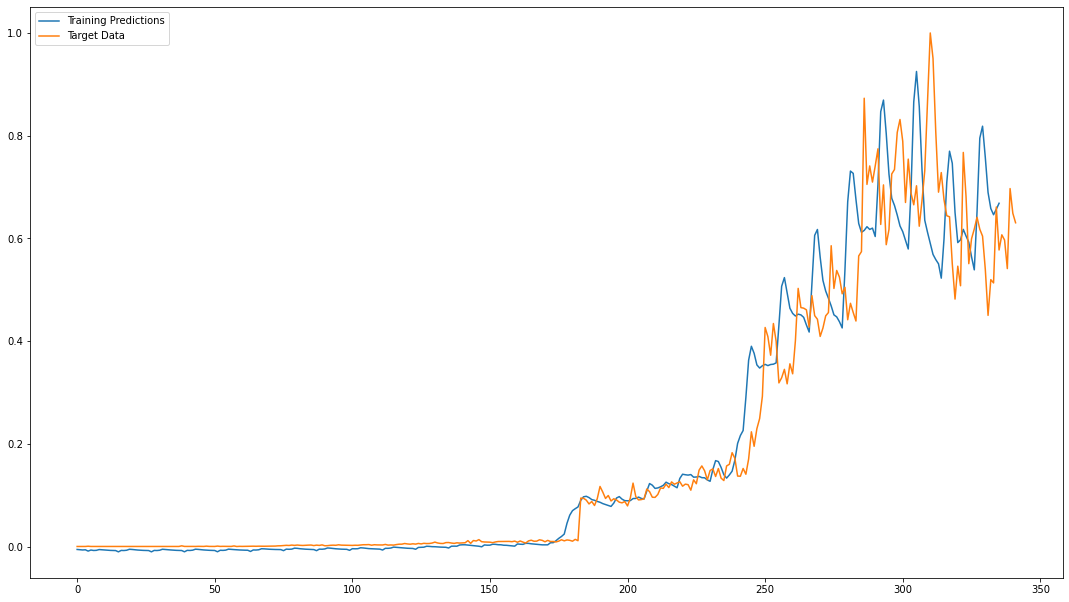

In [30]:
plt.plot( train_predictions)
plt.plot( target)
plt.legend(['Training Predictions', 'Target Data'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)

In [31]:
model.save('./Models/Forst_Arnett_Model.h5')